In [1]:
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr

import chainer
import chainer.functions as F
from chainercv.utils import tile_images

sys.path.append('../experiments/SeqVAE/')
from net import SeqVAE
%matplotlib inline

In [2]:
FILE_PATH = Path('.').resolve()
ROOT_PATH = FILE_PATH.parent
RESULT_PATH = ROOT_PATH.joinpath('results/VAE')
MODEL_PATH = ROOT_PATH.joinpath('models/VAE')
print(FILE_PATH)
print(ROOT_PATH)
print(RESULT_PATH)
print(MODEL_PATH)

/home/shimo/CMULAB/Spatio-Temporal-SR/Notebooks
/home/shimo/CMULAB/Spatio-Temporal-SR
/home/shimo/CMULAB/Spatio-Temporal-SR/results/VAE
/home/shimo/CMULAB/Spatio-Temporal-SR/models/VAE


In [3]:
test_data = np.load(ROOT_PATH.joinpath('datasets/sequence_coil_100_test.npy')) \
              .astype(np.float32).transpose(0,1,4,2,3) / 255.0
train_data = np.load(ROOT_PATH.joinpath('datasets/sequence_coil_100_train.npy')) \
               .astype(np.float32).transpose(0,1,4,2,3) / 255.0
print(test_data.shape, test_data.dtype, train_data.max())
print(train_data.shape, train_data.dtype, train_data.max())

(10, 72, 3, 64, 64) float32 1.0
(90, 72, 3, 64, 64) float32 1.0


In [4]:
model = SeqVAE(64, 3, 100, 8)

chainer.serializers.load_npz(MODEL_PATH.joinpath('coil',
    'preSeqVAE_epoch100_latent100_ch8_coef1.0.npz'), model)

In [5]:
x = test_data[:9, 0]
print(x.shape)

with chainer.using_config('train', False), chainer.no_backprop_mode():
        x_rec = model(x).array \
                .reshape(-1,3, 64, 64)

x_rec = np.clip(np.array(x_rec)*255, 0, 255).astype(np.uint8)
print(x_rec.shape, x_rec.max(), x_rec.min(), x_rec.dtype)

(9, 3, 64, 64)
(9, 3, 64, 64) 249 6 uint8


(9, 3, 64, 64) 249 uint8


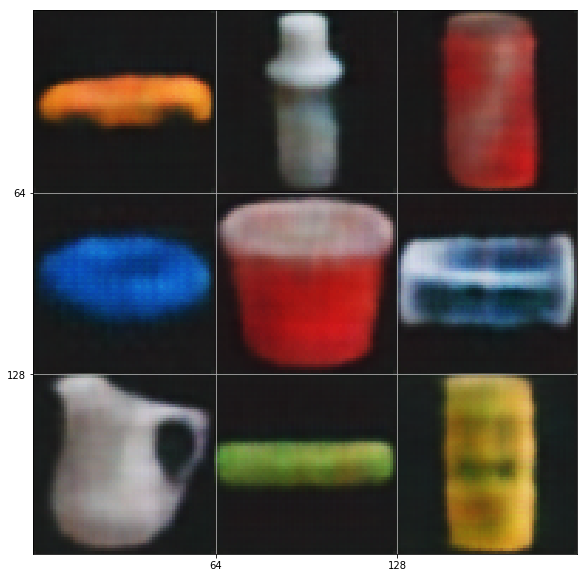

In [6]:
print(x_rec.shape, x_rec.max(), x_rec.dtype)

plt.figure(figsize=(10, 10))
plt.grid(True)
plt.xticks(np.arange(64, 64 * 3, 64))
plt.yticks(np.arange(64, 64 * 3, 64))
plt.imshow(tile_images(x_rec, 3, pad=0, fill=255).transpose(1,2,0), cmap='gray')
plt.imsave('./images/coil_vae_noframe.png',
    tile_images(x_rec, 3, pad=0, fill=255).transpose(1,2,0), cmap='gray')
plt.savefig('./images/coil_vae.png')
plt.show()

In [7]:
# test

psnrs = []
ssims = []

for x_true in tqdm(test_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = model(x_true).array
    x_true = np.clip(x_true*255, 0, 255) \
                .astype(np.uint8).reshape(3,64,64).transpose(1,2,0)
    x_rec = np.clip(x_rec*255, 0, 255) \
                .astype(np.uint8).reshape(3,64,64).transpose(1,2,0)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec, multichannel=True))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

100%|██████████| 10/10 [00:00<00:00, 81.12it/s]

psnr mean 16.24260005198642
ssim mean 0.5872003247760349


In [8]:
# test

psnrs = []
ssims = []

for x_true in tqdm(train_data[:,0]):
    x_true = x_true[np.newaxis, :]
    x_rec = model(x_true).array
    x_true = np.clip(x_true*255, 0, 255) \
                .astype(np.uint8).reshape(3,64,64).transpose(1,2,0)
    x_rec = np.clip(x_rec*255, 0, 255) \
                .astype(np.uint8).reshape(3,64,64).transpose(1,2,0)
    psnrs.append(compare_psnr(x_true, x_rec))
    ssims.append(compare_ssim(x_true, x_rec, multichannel=True))

print("psnr mean", np.mean(psnrs))
print("ssim mean", np.mean(ssims))

100%|██████████| 90/90 [00:01<00:00, 73.24it/s]

psnr mean 17.441833746723425
ssim mean 0.5866872310527947


In [9]:
num_if = 10
seqs = []

midpoint = np.linspace(0, 1, num_if).astype(np.float32).reshape(num_if, 1, 1)

for i in tqdm(range(9)):
    xs = test_data[i, [0, 5, 10],:]
    with chainer.using_config('train', False), chainer.no_backprop_mode():
        zs = model.encode(xs)[0].array
        
        z_01 = zs[0] + np.kron(midpoint, (zs[1] - zs[0]))
        z_12 = zs[1] + np.kron(midpoint, (zs[2] - zs[1]))
        
        x_seq01 = model.decode(z_01.reshape(-1, 100)).array
        x_seq12 = model.decode(z_12.reshape(-1, 100)).array

    x_seq = np.concatenate((x_seq01, x_seq12[1:]), axis=0) \
                .reshape(-1, 3, 64, 64).transpose(2, 0, 3, 1).reshape(64, -1, 3)

    seqs.append(x_seq)

seqs = np.array(seqs)
print(seqs.shape, seqs.max(), seqs.min(), seqs.dtype)

100%|██████████| 9/9 [00:00<00:00, 10.30it/s]

(9, 64, 1216, 3) 0.9981805 0.0028688908 float32


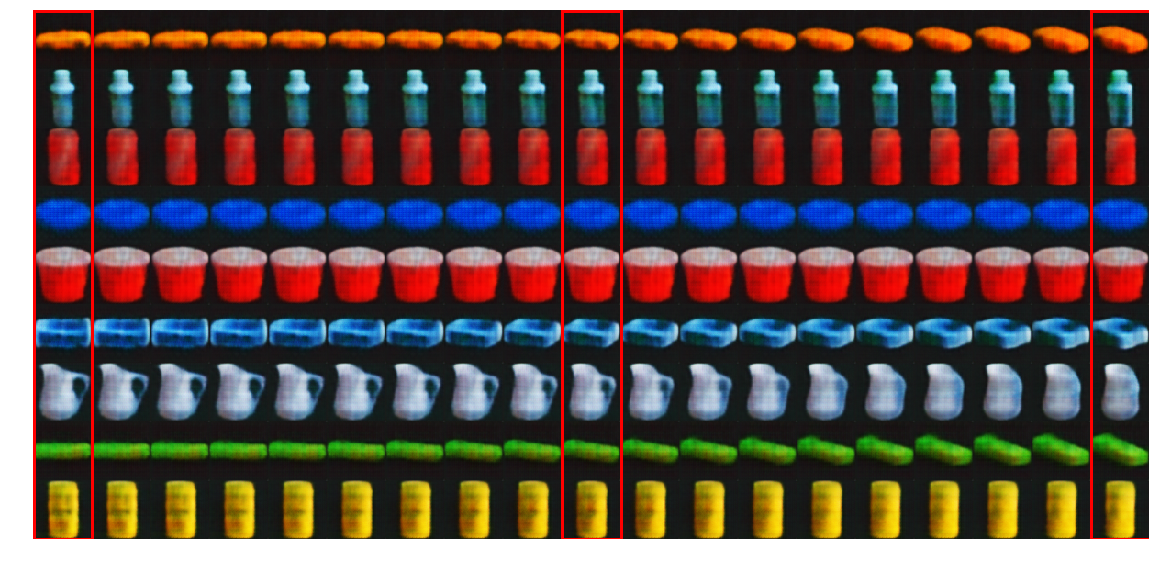

In [10]:
plt.figure(figsize=(20, 10))
plt.imshow(np.clip(seqs*255, 0, 255).astype(np.uint8).reshape(9*64, 19*64, 3),
           cmap='gray')
plt.imsave('./images/sequence_vae_coil_noframe.png',
           np.clip(seqs*255, 0, 255).astype(np.uint8).reshape(64*9, 19*64, 3),
           cmap='gray')
# plt.imshow(seqs_u, cmap='gray')

plt.axis('off')
rect = patches.Rectangle(xy=(0,0),
    width=64, height=64*9, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*9,0),
    width=64, height=64*9, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
rect = patches.Rectangle(xy=(64*18,0),
    width=64, height=64*9, fill=False, ec="red", linewidth="3.0")
ax = plt.gca().add_patch(rect)
plt.savefig('./images/sequence_vae_coil.png')